# Reclamos ciudadanos en Twitter
> Análisis exploratorio de tweets utilizando pandas, scikit-learn y 
- toc: true
- badges: true
- comments: true
- categories: [twitter, nlp, analisis]


## Introducción

Desde hace ya unos años, las redes sociales se volvieron el medio de comunicación preferido de los ciudadanos para realizar reclamos relacionados a la provisión de servicios públicos e infraestructura (electricidad, agua potable, recolección de basura, reportes de baches, etc.)

Si bien esto produjo un avance importante en la comunicación ciudadanía-autoridades, el exceso y la velocidad de generación de la información impide tener un análisis certero de los reclamos como para reaccionar de manera eficaz, entender la causa raíz y prevenir futuros eventos.

Entender esto nos ayudaría por ejemplo a responder las siguientes preguntas:

- ¿Cuáles son los reclamos más frecuentes realizados por los ciudadanos?
- ¿Cómo varía la intensidad de estos reclamos en el tiempo?
- ¿Cuál es el sentimiento de las publicaciones realizadas por los ciudadanos hacia las autoridades?

Con el objetivo de lograr un entendimiento mas profundo que nos permita responder a estas y otras preguntas, utilizo los tweets o publicaciones realizadas en Twitter donde se mencionan a la Municipalidad de Asunción (@AsuncionMuni) y al Intendente (@FerreiroMario1).

## Análisis Exploratorio

### Librerias
En primer lugar, importamos todas las librerias necesarias para el análisis. En este caso, decidí utilizar Pandas para la manipulación de los datos con los conocidos dataframes, seaborn y matplotlib para visualizaciones, NLTK para tokenización, en conjunto con sklearn para implementar técnicas como TF-IDF que son útiles para extraer las combinaciones de palabras más relevantes y como entrada para otras técnicas como LDA, que detallo más adelante.

In [1]:
import datetime, re, spacy, nltk
import calendar
from time import time
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import TweetTokenizer
from nltk import ngrams
import string
import pandas as pd
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Carga de tweets a *pandas* dataframe
Los tweets se encuentran contenidos en un archivo cuya estructura se detalla en el apartado de datos en Kaggle. Además de cargar los tweets a un dataframe de *pandas*, derivo otros atributos que serán útiles más adelante. Extraer algunos tweets de ejemplo puede ser útil para entender los tipos de datos en cada columna.

In [2]:
df_tweets_muni = pd.read_csv("../input/tweets-municipalidad-asuncion/tweets_municipalidad.csv")
df_tweets_muni['created_at'] = pd.to_datetime(df_tweets_muni['created_at'])
df_tweets_muni['date'] = pd.to_datetime(df_tweets_muni['created_at'].dt.date)
df_tweets_muni['month'] = df_tweets_muni['date'].dt.month
df_tweets_muni['year'] = df_tweets_muni['date'].dt.year
df_tweets_muni['tweet'] = df_tweets_muni['tweet'].astype(str)
df_tweets_muni['year_month'] = df_tweets_muni['date'].dt.to_period('M')

In [3]:
df_tweets_muni.head(5)

,created_at,tweet,username,date,month,year,year_month
0,2017-10-30 23:57:03+00:00,exelente saludos desde nycity,renevera2013,2017-10-30,10,2017,2017-10
1,2017-10-30 23:50:51+00:00,"Ahora mismo 5 autos ""agarran"" el carril derech...",Superman74Cacer,2017-10-30,10,2017,2017-10
2,2017-10-30 23:50:01+00:00,Siempre la misma cosa frente a CASACOR...,Superman74Cacer,2017-10-30,10,2017,2017-10
3,2017-10-30 23:47:24+00:00,ESAS PAREDES....SE TIENE QUE LLAMAR A LOS CAND...,aweissman1950,2017-10-30,10,2017,2017-10
4,2017-10-30 23:46:34+00:00,Hacen años que ahí no se puede girar a la izqu...,aristidesag,2017-10-30,10,2017,2017-10


### Deduplicación y filtrado

En las siguientes celdas, elimino los tweets duplicados que puedieron aparecer al realizar la extracción o en caso que usuarios hayan publicado el mismo tweet varias veces.

Luego, identifico los usuarios con más cantidad de tweets y excluyo aquellas cuentas relacionadas a la Municipalidad, medios de comunicación u otros entes públicos de tal manera a considerar únicamente las publicaciones de los ciudadanos.

In [4]:
# Borrar tweets duplicados (nos quedamos con el primero)
df_tweets_muni = df_tweets_muni.drop_duplicates(subset=['tweet'], keep='first')

In [5]:
# Usuarios con mas tweets
df_tweets_username = df_tweets_muni.groupby('username').count().reset_index()
df_tweets_username.sort_values(by='tweet', ascending=False)[['username','tweet']].head(10)

,username,tweet
26216,pmtasuncion1,11679
1413,AsuncionMuni,4881
1409,AsuDsu,3273
3830,El_Rafa_PY,1984
247,ABCCardinal,1207
7146,LaUnionAM,1182
194,780AM,1071
28362,teclitamovil,841
1408,AsuDgrrd,731
15991,chrispresspy,722


In [6]:
# Excluir cuentas de la municipalidad o de medios de comunicacion
filtro = ~(df_tweets_muni['username'].isin(['AsuncionMuni','pmtasuncion1','AsuDsu','ABCCardinal',
                                           'LaUnionAM', '780AM', 'AsuDgrrd', 'Universo970py', 
                                           '1000_am', 'EssapSA', 'Ferreiromario1', 'AbastoAsu',
                                           'ANDEOficial', 'mopcparaguay']))

# Crear copia de dataframe con filtro aplicado
df_tweets_muni_filtro = df_tweets_muni[filtro].copy()

### Limpieza
Los tweets publicados pueden tener información poco relevante para análisis textuales como por ejemplo URLs, emails, referencias a imagenes o simbolos. Además, existen palabras conocidas como stopwords que se repiten frecuentemente y no aportan al entendimiento de la conversación (el, la, y, con, para, mi, etc.). NLTK es una librería de NLP que incluye stopwords en diferentes idiomas, incluyendo español.

In [7]:
# Cargar stopwords en español
stopwords_es = stopwords.words('spanish')

"""
Excluir menciones, emails, URLs y simbolos
"""
def clean_tweet(tweet):
    # Convertir a minusculas
    tweet = tweet.lower()
    
    # Excluir menciones o emails
    tweet = re.sub(r'\w*@(\w+\.*\w+\.*\w+)',' ', tweet)
    
    # Excluir simbolos
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    
    # Excluir URLs 
    tweet = re.sub(r'(?:www\.|https?)[^\s]+', ' ', tweet, flags=re.MULTILINE) 
    
    # Borrar espacios
    tweet = tweet.strip()
    
    # Considerar solo valores alfa numericos
    tweet_alfa = re.compile("^(?![0-9]*$)[a-zA-Z0-9]+$") 
    
    # Eliminar stopwords y palabras con longitud <= 2
    tokens = tweet.split()
    text = [token for token in tokens if token not in stopwords_es and len(token)>2 and tweet_alfa.match(token)]
    return ' '.join(text)

# Aplicar filtro a tweets
df_tweets_muni_filtro['tweet_cleaned'] = df_tweets_muni_filtro['tweet'].apply(clean_tweet)

### Bigramas frecuentes por año
Los bigramas son combinaciones de dos palabras que pueden dar una mejor idea de los temas de conversación. En este caso, me interesa conocer los bigramas que más se repiten y para ellos aplico técnicas de tokenización que separan las palabras del texto y cada par se convierte en una fila. También se puede modificar el tamaño del ngram para formar unigramas, trigramas, etc. El bigrama es una opción intermedia que permite tener algo más de contexto pero tiene suficientes ocurrencias para que sea significativa la muestra (mientras mayor sea el ngram, menor el número de ocurrencias).

In [8]:
# Tamano del ngram
ngram = 2
tokenizer = TweetTokenizer()

# Tokenizar y aplicar ngram
df_tweets_muni_filtro['tokenize'] = df_tweets_muni_filtro['tweet_cleaned'] \
                            .apply(tokenizer.tokenize)
df_tweets_muni_filtro['ngram'] = df_tweets_muni_filtro['tokenize'] \
                            .apply(lambda x: list(ngrams(x, ngram)))

# Una fila por ngram
df_tweets_muni_exploded = df_tweets_muni_filtro \
                          .explode('ngram')[['date','year','ngram']]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: generator 'ngrams' raised StopIteration
  if __name__ == '__main__':


In [9]:
# Agrupar por cantidad de ocurrencias
df_tweets_muni_exploded_grouped = df_tweets_muni_exploded \
        .groupby(['year', 'ngram'])  \
        .agg({'date':'count'}) \
        .reset_index() \
        .sort_values(by=['year', 'date'], ascending=False) \
        .rename(columns={'date':'count'})

# Top 10 por YYYY
df_tweets_muni_top_year = df_tweets_muni_exploded_grouped \
    .drop_duplicates(subset=['count','year']) \
    .groupby(['year']) \
    .head(10)

La siguiente gráfica muestra las ocurrencias de cada bigrama por año. Se pueden identificar por ejemplo bigramas que aparecen en multiples años

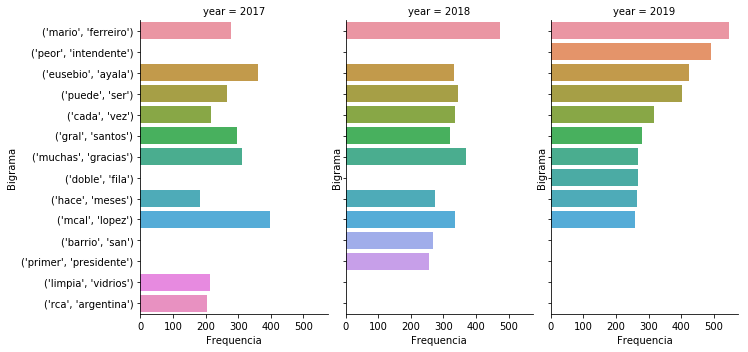

In [10]:
import seaborn as sns
ax = sns.catplot(x="count",y="ngram",
                   col="year",
                   data=df_tweets_muni_top_year, kind="bar",
                   height=5, aspect=.7);
ax.set(xlabel="Frequencia", ylabel="Bigrama")

### Wordcloud
Las nubes de palabras o word clouds permiten visualizar las palabras más frecuentes de un texto utilizando el tamaño para representar la frecuencia o importancia. En este caso, las palabras se extraen de los tweets filtrados (cerca de 200.000).

Para volverlo un poco más divertido y patriota, utilizo un fondo con nuestra bandera pero se puede adaptar a cualquier tipo de imagen.

(-0.5, 594.5, 223.5, -0.5)

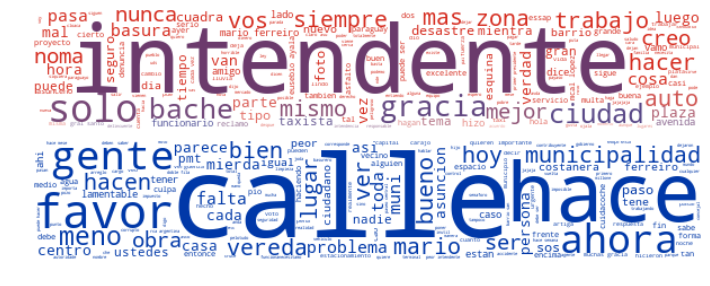

In [11]:
# Generación de un wordcloud paraguayo
texto_tweets = ' '.join(df_tweets_muni_filtro['tweet_cleaned'])

mask = np.array(Image.open("../input/paraguay-flag/paraguay_flag_.png"))
wordcloud_py = WordCloud(background_color="white", mode="RGBA", max_words=1000, mask=mask).generate(texto_tweets)

# Utilización de colores de la imagen 
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[12,8])
plt.imshow(wordcloud_py.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

### Usuarios únicos
La cantidad de usuarios únicos que publican tweets nos puede ayudar a identificar situaciones que provocaron mayores picos de participación en el tiempo. Si nos fijamos la gráfica de abajo, se observan ciertos picos en el 2019, tanto en Mayo como en Julio. 
¿Qué se mencionaba con frecuencia en estas fechas?

In [12]:
df_unique_users = df_tweets_muni_filtro.groupby(['date'])['username'].nunique()

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Fecha')

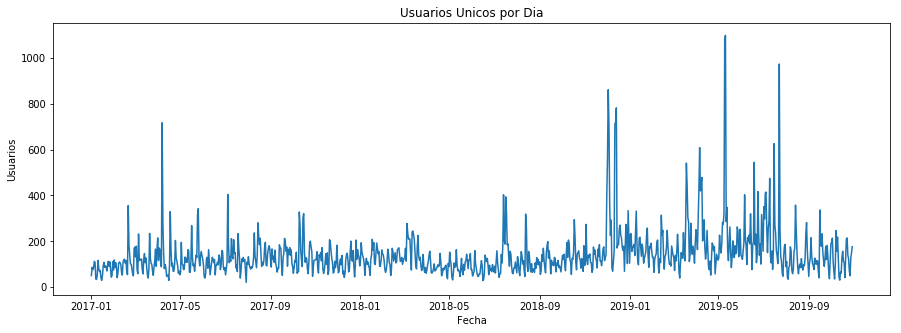

In [13]:
fig = plt.figure(figsize=(15,5))

sns.lineplot(x='date', y='username', data=df_unique_users.reset_index())

plt.title('Usuarios Unicos por Dia')
plt.ylabel('Usuarios')
plt.xlabel('Fecha')

In [14]:
df_unique_users.reset_index().sort_values('username', ascending=False).head(5)

,date,username
854,2019-05-11,1098
853,2019-05-10,1083
926,2019-07-23,973
698,2018-12-03,861
709,2018-12-14,782


"gente puerca", "basura calle", "tira basura".. estos bigramas dan para pensar que en estas fechas pudo haber llovido con mucha frequencia, lo que pudo haber ocasionado raudales que a su vez movieron las basuras de un lado para otro. 

Text(0, 0.5, 'Bigrama')

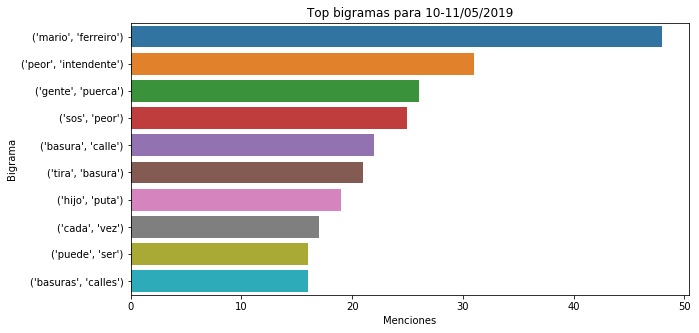

In [15]:
fig = plt.figure(figsize=(10,5))

df_top_unique_days = df_tweets_muni_exploded[df_tweets_muni_exploded['date'].isin(['2019-05-10','2019-05-11'])] \
        .groupby('ngram') \
        .count() \
        .reset_index() \
        .sort_values('date', ascending=False) \
        .head(10)
        
sns.barplot(x='date', y='ngram', data=df_top_unique_days, orient='h')

plt.title('Top bigramas para 10-11/05/2019')
plt.xlabel('Menciones')
plt.ylabel('Bigrama')

### Análisis por eventos
Con lo analizado hasta ahora, tenemos una leve idea de los temas de conversación. Además, existen otros temas que pueden ser interesantes y no se encuentran a simple vista. Para entender un poco mejor como estos temas se mencionan en el tiempo, utilizo expresiones regulares que de acuerdo a ciertos patrones de búsqueda identifiquen tweets relacionados a los temas que nos interesan. En este caso, elegí los siguientes temas que me parecieron los más reclamados por la ciudadanía: **basura, raudales, baches y dengue**. Es importante tener en cuenta que un mismo tweet puede pertenecer a mas de una categoria porque de hecho puede existir correlacion entre varios de estos temas.

In [16]:
# Filtrar tweets por categorias de acuerdo a palabras claves
def get_df_from_criteria(df, criteria):
    df = df[df['tweet_cleaned'] \
            .str \
            .contains(criteria, flags=re.IGNORECASE, regex=True)] \
            .groupby(['date','year','month'], as_index=False) \
            .agg(['count'])['created_at'].reset_index().rename(columns={'count':'tweets'})
    return df.copy()

filtro_baches = r'\bbache|\bvache|\bcrater'
baches_x_dia_df = get_df_from_criteria(df_tweets_muni_filtro, filtro_baches)

filtro_basura = r'\bbasura|\brecicla|\bdesecho|\btoxico|\bvertedero|\bescombro|\bsucio|\basco'
basura_x_dia_df = get_df_from_criteria(df_tweets_muni_filtro, filtro_basura)
 
filtro_inundado = r'\binunda|\blluvia|\bllueve|\braudal|\bdesagu*'    
inundado_x_dia_df = get_df_from_criteria(df_tweets_muni_filtro, filtro_inundado)

filtro_dengue = r'\bdengue|\bmosquito|\baedes|\bcriadero|\bminga|\bfumiga'
dengue_x_dia_df = get_df_from_criteria(df_tweets_muni_filtro, filtro_dengue)   

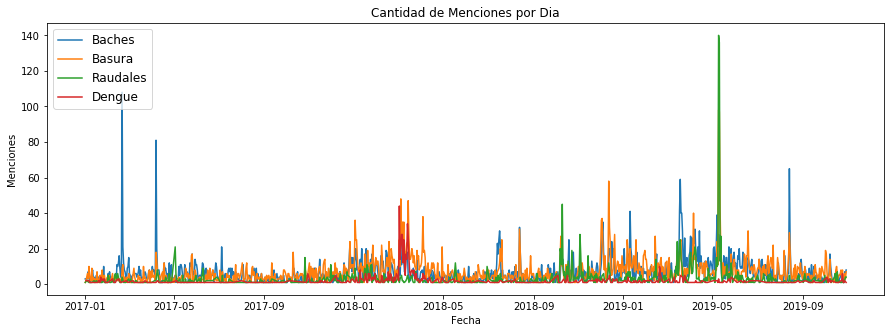

In [17]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)

sns.lineplot(x='date', y='tweets', data=baches_x_dia_df[baches_x_dia_df['year'].isin([2017,2018,2019])], ax=ax)
sns.lineplot(x='date', y='tweets', data=basura_x_dia_df[basura_x_dia_df['year'].isin([2017,2018,2019])], ax=ax)
sns.lineplot(x='date', y='tweets', data=inundado_x_dia_df[inundado_x_dia_df['year'].isin([2017,2018,2019])], ax=ax)
sns.lineplot(x='date', y='tweets', data=dengue_x_dia_df[dengue_x_dia_df['year'].isin([2017,2018,2019])], ax=ax)

plt.title('Cantidad de Menciones por Dia')
plt.ylabel('Menciones')
plt.xlabel('Fecha')

ax.legend(['Baches', 'Basura', 'Raudales', 'Dengue'], loc='upper left', prop={'size': 12})

En Mayo vemos picos de menciones a raudales que coinciden con los picos de usuarios unicos que vimos mas arriba. También se observa un pico de conversaciones relacionadas al dengue en Marzo de 2018 que coincide con uno de los brotes mas importantes en los últimos años.

Para facilitar comparaciones interanuales, en las próximas gráficas podemos ver para cada tema como cambian las menciones en el tiempo. En el caso de dengue por ejemplo, se observa un aumento importante en Marzo de 2018. Por otro lado, en las menciones de raudales se ve un crecimiento notorio en Mayo de 2019 en comparación con años anteriores.

Text(0, 0.5, 'Menciones (Dengue)')

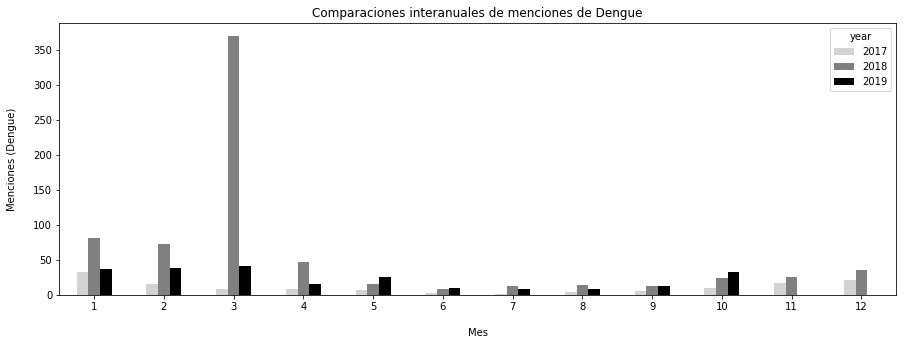

In [18]:
# Agrupar por mes
dengue_x_mes_df = dengue_x_dia_df.groupby(['year','month']) \
                    .sum().reset_index()[['month','year','tweets']]

# Pivotear
dengue_x_mes_pivot = dengue_x_mes_df \
                    .pivot(index='month',columns='year', values='tweets')
    
dengue_x_mes_pivot.plot(kind='bar', figsize=(15, 5), color=['lightgray', 'gray', 'black'], rot=0)                                       
plt.title("Comparaciones interanuales de menciones de Dengue")
plt.xlabel("Mes", labelpad=16)
plt.ylabel("Menciones (Dengue)", labelpad=16)

Text(0, 0.5, 'Menciones (Basura)')

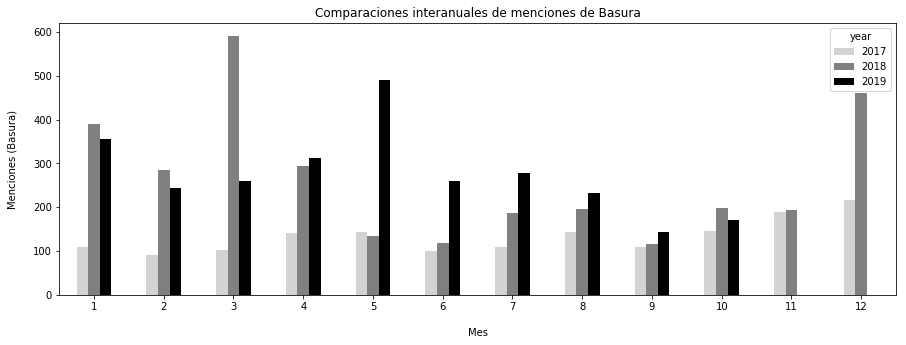

In [19]:
# Agrupar por mes
basura_x_mes_df = basura_x_dia_df.groupby(['year','month']) \
                    .sum().reset_index()[['month','year','tweets']]
    
# Pivotear
basura_x_mes_pivot = basura_x_mes_df \
                    .pivot(index='month',columns='year', values='tweets')

basura_x_mes_pivot.plot(kind='bar', figsize=(15, 5), color=['lightgray', 'gray', 'black'], rot=0)                                       
plt.title("Comparaciones interanuales de menciones de Basura")
plt.xlabel("Mes", labelpad=16)
plt.ylabel("Menciones (Basura)", labelpad=16)

Text(0, 0.5, 'Menciones (Raudales)')

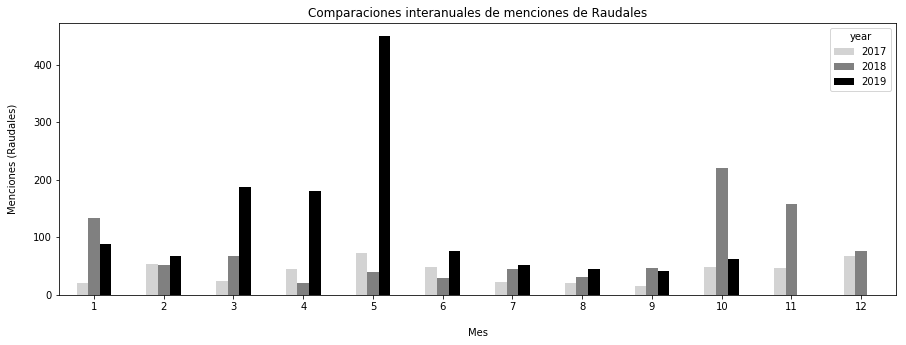

In [20]:
# Agrupar por mes
inundado_x_mes_df = inundado_x_dia_df.groupby(['year','month']) \
                    .sum().reset_index()[['month','year','tweets']]

# Pivotear
inundado_x_mes_pivot = inundado_x_mes_df \
                    .pivot(index='month',columns='year', values='tweets')
    
inundado_x_mes_pivot.plot(kind='bar', figsize=(15, 5), color=['lightgray', 'gray', 'black'], rot=0)                                       
plt.title("Comparaciones interanuales de menciones de Raudales")
plt.xlabel("Mes", labelpad=16)
plt.ylabel("Menciones (Raudales)", labelpad=16)

## Modelado de Topicos con LDA
Para casos como este, dónde tenemos una buena idea de los temas de conversación en los tweets, las expresiones regulares pueden ser suficientes. Sin embargo, existen otros casos dónde se necesitan de técnicas más avanzadas para identificar temas que pueden estar escondidos, o latentes. 

Existen diferentes técnicas de identificación de temas o tópicos pero una de las más utilizadas es Latent Dirichlet Allocation o LDA. Se trata de una técnica que genera un modelo probabilístico que asume que cada tema es una combinación de palabras y que cada documento (o tweet en este caso) es una combinación de temas con diferentes probabilidades.

En las celdas de abajo, creo un Pipeline que primero aplica una técnica conocida como TF-IDF que calcula la frecuencia de palabras en los tweets, y calcula un score para cada palabra dando menos importancia a aquellas que aparecen con demasiada frecuencia y son poco relevantes. En el siguiente paso del pipeline se entrena el modelo y transforma el dataframe original. En este caso, elijo clasificar los temas en 5 diferentes categorias pero el número puede variar de acuerdo al caso. Existen formas de medir la calidad del modelo, calculando lo que se denomina *perplexity* pero no lo voy a utilizar en este caso.

Otro punto importante es que el entrenamiento del modelo puede tomar mucho tiempo y por esto es clave definir ciertos parametros que limiten la busqueda y la cantidad de iteraciones. 

In [21]:
# Cantidad de topicos
n_topics = 5

# Pipeline con pasos a ejectuar
text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(2,3), min_df=100, max_df=0.85)),
    ('lda', LatentDirichletAllocation(n_components=n_topics, max_iter=5, learning_method='online'))
])
t0 = time()
# Entrenar y transformar modelo
lda_model = text_pipeline.fit_transform(df_tweets_muni_filtro['tweet_cleaned'])
print(time() - t0)

129.6550097465515


In [22]:
# Modelos resultantes del pipeline
tfidf = text_pipeline.steps[0][1]
lda = text_pipeline.steps[1][1]
vocabulario = tfidf.get_feature_names()

In [23]:
top_topics = 5
topic_dict = {}
topic_scores = []

# Para cada topico, buscamos el top 5 de acuerdo a los scores calculados por el modelo
for topic_idx, topic in enumerate(lda.components_):
    topic_dict[str(topic_idx)] = ",".join([vocabulario[i] for i in topic.argsort()[:-top_topics - 1:-1]])
    topic_scores.append([topic[i] for i in topic.argsort()[:-top_topics - 1:-1]])
df_topics_lda = pd.DataFrame(topic_dict, index=['bigrams'])
df_topics_lda = df_topics_lda.T.reset_index()

# Cargamos las palabras claves por topico en un dataframe
df_topics_names = pd.DataFrame(df_topics_lda.bigrams.str.split(',').tolist(), index=df_topics_lda.index) \
            .stack() \
            .reset_index() \
            .drop(['level_1'], axis=1) \
            .rename(columns={0:'bigrams', 'level_0':'topic'})

# Cargamos scores por topicos en un dataframe
df_topics_scores = pd.DataFrame(topic_scores) \
        .stack() \
        .reset_index(drop=True)

# Concatenamos palabras claves con scores correspondientes
df_topics = pd.concat([df_topics_names, df_topics_scores], axis=1) \
        .rename(columns={0:'score'})
    

Finalmente se observan los bigramas mas frecuentes para cada una de las categorias. No se identifican categorias especificas y esto puede deberse a que no existe una diferenciacion muy clara entre los temas de conversacion. También se pueden obtener mejores resultados realizando validaciones adicionales y excluyendo otras combinaciones poco relevantes.

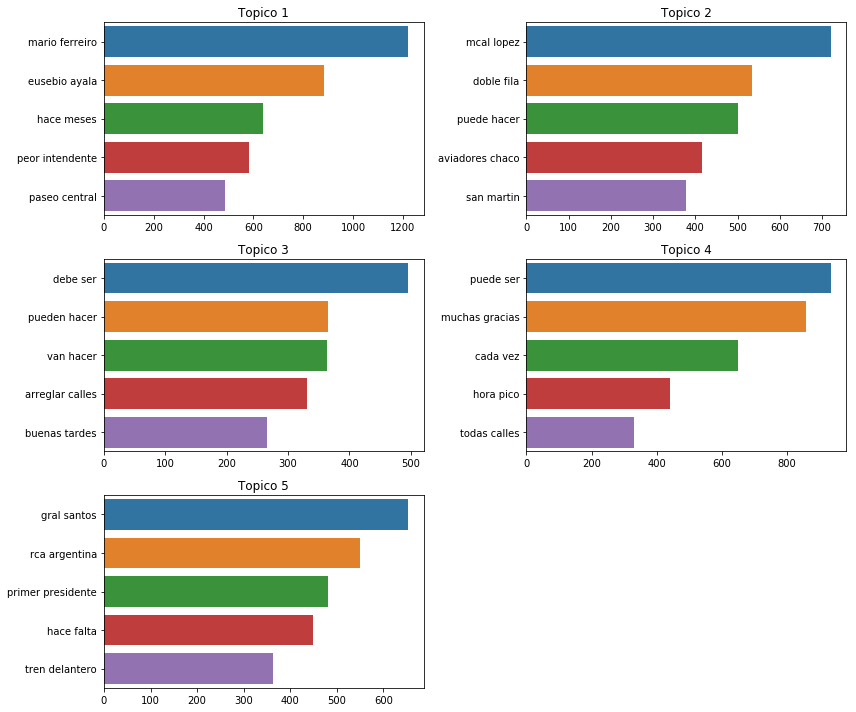

In [24]:
fig = plt.figure(figsize=(12,10))

for i in range(1,n_topics+1):    
    plt.subplot(3,2,i,frameon=True)
    sns.barplot('score', 'bigrams', data=df_topics[df_topics['topic']==i-1], orient='h') 
    plt.title("Topico {}".format(i))
    plt.xlabel('')
    plt.ylabel('')
    plt.tight_layout()

## Otros análisis que se podrian realizar con estos datos:
- Análisis de sentimiento
- Correlación entre temas y visualización con *scattertext*
- Series temporales para predecir eventos (como brotes de dengue)